# **Exercise #2**

The graph atsp04062019R1.gml represents a logistic distribution network.

A company must deliver one unit of a certain product to customers located in the nodes.
The company can implement the following delivering plans:
- Q1.Rent a vehicle with capacity C=50 at a cost of 3400 Euro/day
- Q2.Rent one vehicle with capacity C=18 at a cost of 1100 Euro/day and rent a warehouse in node 16 able to store products at a cost of 2100 Euro/day
- Q3.Rent two vehicles with capacity C=18   at a cost of 1650 Euro/day per vehicleFind the most convenient delivering plan. 

For each alternative report the optimal solution, the value of the linear relaxation and the number of enumerated nodes

In [30]:
costs = [3400, 1100+2100, 1650*2]
solutions = []

In [31]:
import gurobipy as gb
import networkx as nx
import matplotlib.pyplot as plt
import os


#
# Drawing 
# functions
#


def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
        

    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        


        
        
    
    plt.axis('off')
    plt.show()


def DrawSubtour (G, x, subtour):

    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}


    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o',
                           nodelist=subtour,
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    

    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    subtouredges = [(u,v) for u in subtour for v in subtour if u != v and G.has_edge(u,v)]
    
    for u,v in subtouredges:
        if x[u,v].x > 0.01 and x[u,v].x < 0.99:

            nx.draw_networkx_edges(G, pos=pos,\
                                   edgelist=[(u,v)],
                                   edge_color='r')

            nx.draw_networkx_edge_labels(G, pos=pos, 
                                         edge_labels={(u,v):f'[{x[u,v].x:.2f}, {x[v,u].x:.2f}]'})

            
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,\
                                   edgelist=[(u,v)],\
                                   edge_color='k')
            
    plt.axis('off')
    plt.show()
    
class args:
    filename = None
    scale = 15
    figsize = (10,10)

## mTSP

>**Given**
>A directed graph $G=(N,A)\;$ and a cost $c_{ij} > 0$ for each arc in $A$
>
>**Find**
> A set of routes for $m$ salesmen who all start from and turn back to a home city (depot, node 1) 
 


### Formulation

Decision variables:
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the tour} \\
0 \text{ otherwise}
\end{cases}
$$

Formulation:
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} c_{ij} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j = 2}^{j=n} x_{1j} &= m  \;\; \text{(OUT-R)}\\
\sum_{i = 2}^{i=n} x_{i1} &= m \;\; \text{(IN-R)}\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(RS)}\\
\sum_{(i,j) \in A(S)} x_{ij} &\le |S| - 1 \;\; \forall S \subset N \setminus \{1\}, |S| \ge 2 \;\; \text{(SEC)}\\
\text {or}\\
\sum_{(i,j) \in \delta^+(S)} x_{ij} &\ge 1 \;\; \forall S \subset N, \{1\} \in S\\
x & \in \{0,1\}^{|A|}
\end{alignat}
$$

In [32]:
# Read the graph in the graphML format

args.filename = 'atsp04062019R1.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

print(G.is_directed())

args.figsize = (20,20)

#print(G.edges(data=True))
#print(G.nodes(data=True))

G has 30 nodes and 870 edges
True


In [33]:
root = list(G.nodes())[0]

## mTSP MTZ constraints

### Formulation

Decision variables:
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the tour} \\
0 \text{ otherwise}
\end{cases}
$$

Formulation:
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} c_{ij} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j = 2}^{j=n} x_{1j} &= m  \;\; \text{(OUT-R)}\\
\sum_{i = 2}^{i=n} x_{i1} &= m \;\; \text{(IN-R)}\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(RS)}\\
u_i - u_j + p x_{ij} &\le p-1 \;\; \forall (i,j) \in A, i,j \not = 1\\
x & \in \{0,1\}^{|A|}
\end{alignat}
$$

## **Ex.2_Q1 ->**  Rent a vehicle with capacity C=50 at a cost of 3400 Euro/day

In [34]:
m = 1
p = 50

In [35]:
mtsp_mtz = gb.Model()

## Variables
x = mtsp_mtz.addVars(G.edges(),\
                 obj=[G[i][j]['dist']\
                      for i,j in G.edges()],\
             vtype=gb.GRB.BINARY, name='x')

u = mtsp_mtz.addVars(G.nodes(), obj=0.0, vtype=gb.GRB.CONTINUOUS,\
                     lb=1.0, ub=p, name='u')

## Constraints
mtsp_mtz.addConstr(x.sum(root,'*') == m, name = 'OUT-R')
mtsp_mtz.addConstr(x.sum('*',root) == m, name = 'IN-R')

mtsp_mtz.addConstrs((x.sum(i,'*') == 1 \
                 for i in G.nodes() if i != root), name='FS')

mtsp_mtz.addConstrs((x.sum('*',i) == 1 \
                 for i in G.nodes() if i != root), name='RS')

mtsp_mtz.addConstrs((x[i,j] + x[j,i] <= 1 \
                 for i,j in G.edges() if j > i \
                     and i != root and j != root ), name='SUB2')

u[root].lb = 0
u[root].ub = 0

mtsp_mtz.addConstrs((u[i] - u[j] + p * x[i,j] <= p - 1 \
                     for i in G.nodes() for j in G.nodes()\
                    if i != j and i != root and j != root and G.has_edge(i,j)), name='MTZ')

mtsp_mtz._graph = G
mtsp_mtz._vars = x

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1278 rows, 900 columns and 4988 nonzeros
Model fingerprint: 0xd7ca470f
Variable types: 30 continuous, 870 integer (870 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [2e+02, 7e+03]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolved: 1278 rows, 899 columns, 4988 nonzeros
Variable types: 29 continuous, 870 integer (870 binary)
Found heuristic solution: objective 80645.000000

Root relaxation: objective 2.654122e+04, 137 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 26541.2200    0   59 80645.0000 26541.2200  67.1%     -    0s
H    0     0                    32586.000000 

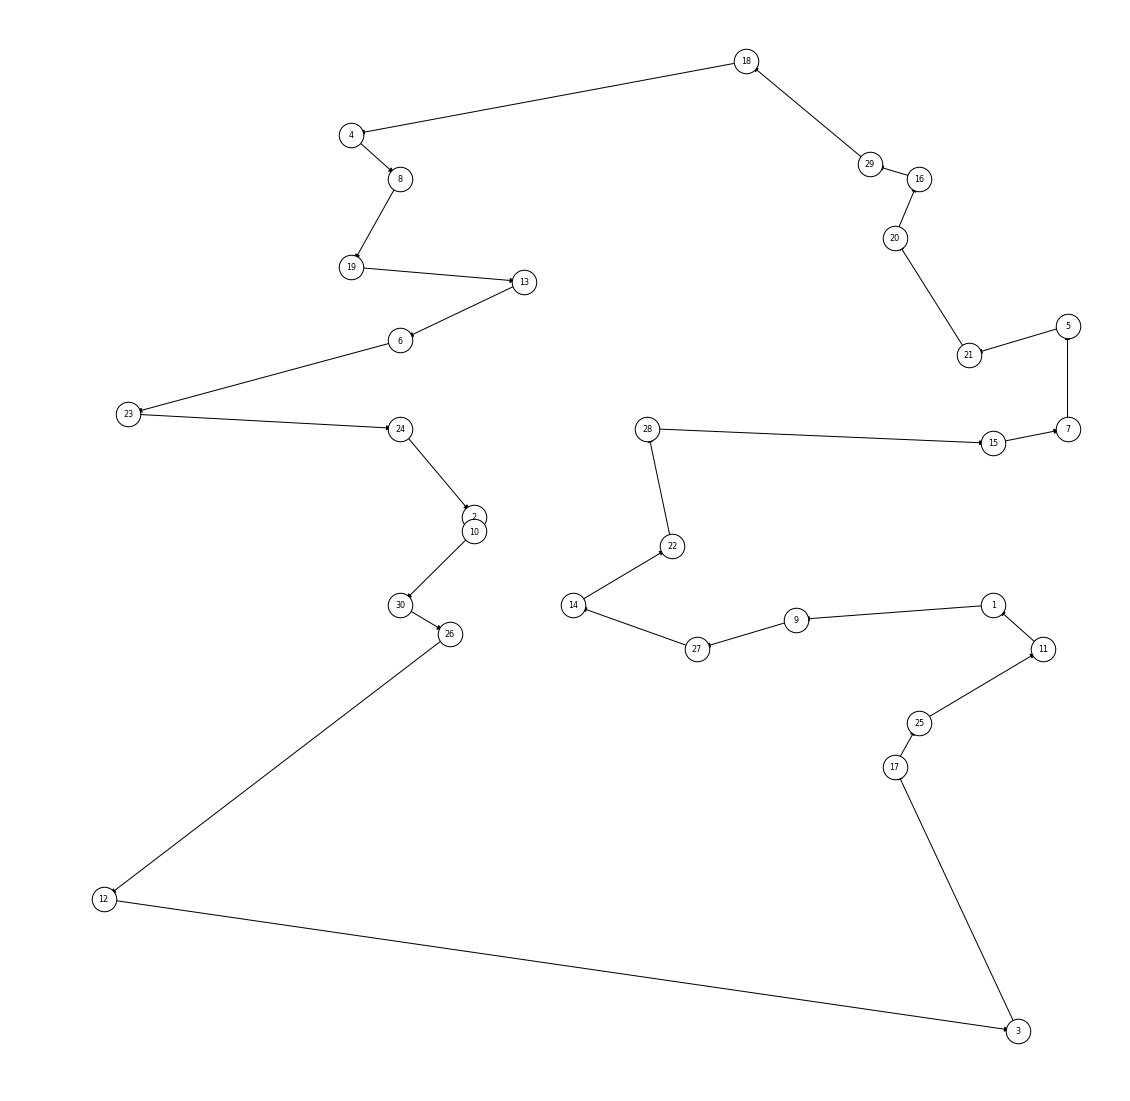

In [36]:
mtsp_mtz.optimize()
solutions.append(mtsp_mtz.objVal)

print("\n------------------------------------------------------------------------------\n")
print ("-> Solution", mtsp_mtz.objVal)
print("\n------------------------------------------------------------------------------\n")

DrawSol(G, x)

## **Ex2_Q2 ->** Rent one vehicle with capacity C=18 at a cost of 1100 Euro/day and rent a warehouse in node 16 able to store products at a cost of 2100 Euro/day

we can solve the problem by:
- fixing the maximum distance of the wharehouse from the root to the capacity of the vehicle, plus 1, because the wharehouse doesn't require a unit of goods
- fixing the minimum to the difference beetween the number of nodes and the capacity of the vehicle, plus one for the same reason as before
- Lastly we just need to double the capacity of the veicle 

In [37]:
m = 1
p = 36

In [38]:
mtsp_mtz = gb.Model()

## Variables
x1 = mtsp_mtz.addVars(G.edges(),\
                 obj=[G[i][j]['dist']\
                      for i,j in G.edges()],\
             vtype=gb.GRB.BINARY, name='x')

u1 = mtsp_mtz.addVars(G.nodes(), obj=0.0, vtype=gb.GRB.CONTINUOUS,\
                     lb=1.0, ub=p, name='u')

## Constraints
mtsp_mtz.addConstr(x1.sum(root,'*') == m, name = 'OUT-R')
mtsp_mtz.addConstr(x1.sum('*',root) == m, name = 'IN-R')

mtsp_mtz.addConstrs((x1.sum(i,'*') == 1 \
                 for i in G.nodes() if i != root), name='FS')

mtsp_mtz.addConstrs((x1.sum('*',i) == 1 \
                 for i in G.nodes() if i != root), name='RS')

mtsp_mtz.addConstrs((x1[i,j] + x1[j,i] <= 1 \
                 for i,j in G.edges() if j > i \
                     and i != root and j != root ), name='SUB2')

u1[root].lb = 0
u1[root].ub = 0

# fix the wharehouse upper bound
u1[16].lb = len(G.nodes())-18+1
u1[16].ub = 18+1

mtsp_mtz.addConstrs((u1[i] - u1[j] + p * x1[i,j] <= p - 1 \
                     for i in G.nodes() for j in G.nodes()\
                    if i != j and i != root and j != root and G.has_edge(i,j)), name='MTZ')

mtsp_mtz._graph = G
mtsp_mtz._vars = x1

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1278 rows, 900 columns and 4988 nonzeros
Model fingerprint: 0xfb4bc9a4
Variable types: 30 continuous, 870 integer (870 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [2e+02, 7e+03]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolved: 1278 rows, 899 columns, 4988 nonzeros
Variable types: 29 continuous, 870 integer (870 binary)
Found heuristic solution: objective 85932.000000

Root relaxation: objective 2.654601e+04, 134 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 26546.0102    0   59 85932.0000 26546.0102  69.1%     -    0s
H    0     0                    33738.000000 

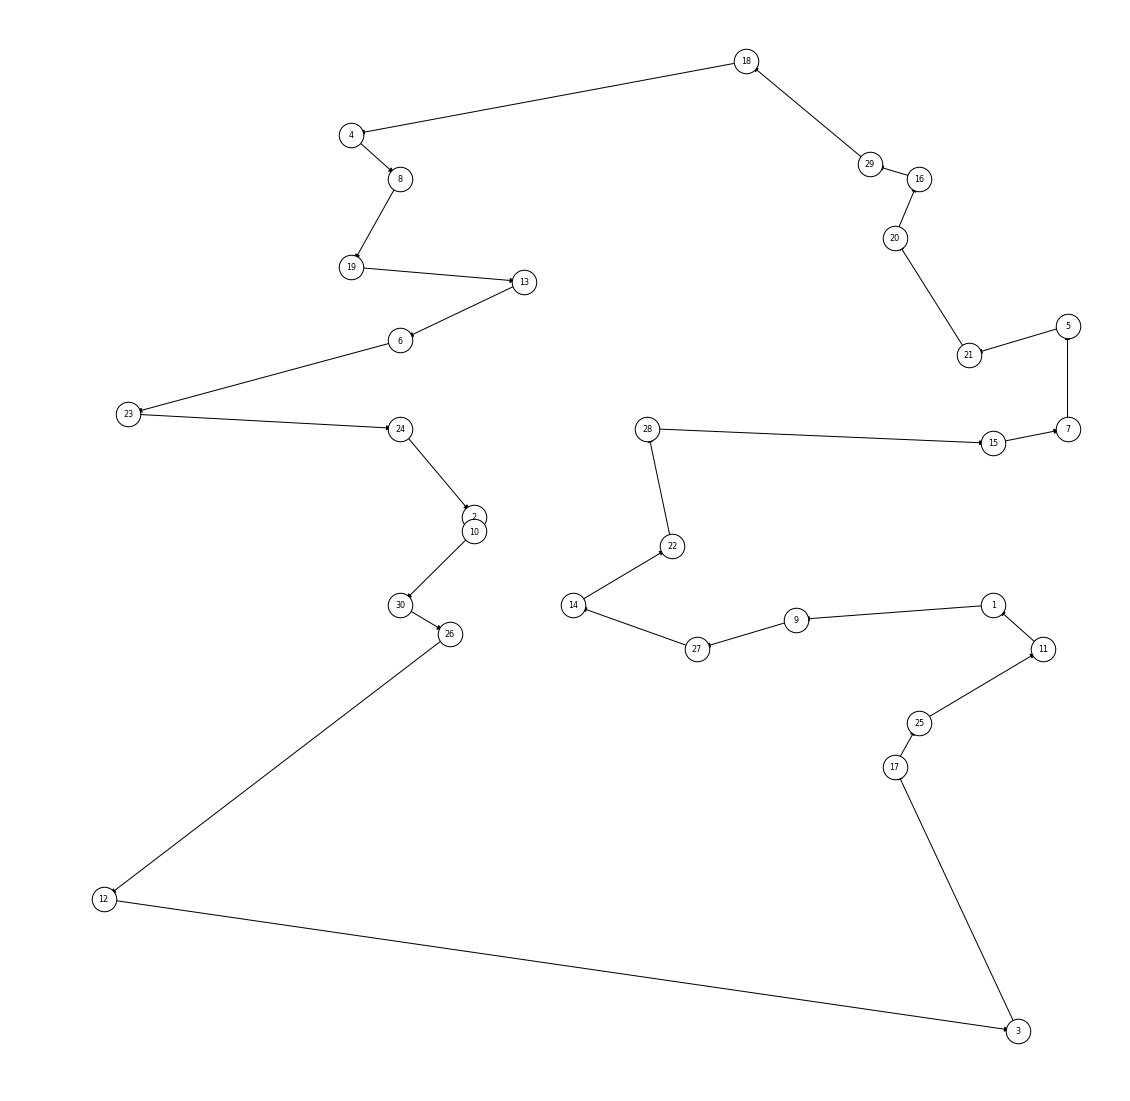

In [39]:
mtsp_mtz.optimize()
solutions.append(mtsp_mtz.objVal)

print("\n------------------------------------------------------------------------------\n")
print ("-> Solution", mtsp_mtz.objVal)
print("\n------------------------------------------------------------------------------\n")

DrawSol(G, x1)

## **Ex2_Q3 ->** Rent two vehicles with capacity C=18   at a cost of 1650 Euro/day per vehicleFind the most convenient delivering plan. 

In [40]:
m = 2
p = 18

In [41]:
mtsp_mtz = gb.Model()

## Variables
x2 = mtsp_mtz.addVars(G.edges(),\
                 obj=[G[i][j]['dist']\
                      for i,j in G.edges()],\
             vtype=gb.GRB.BINARY, name='x')

u2 = mtsp_mtz.addVars(G.nodes(), obj=0.0, vtype=gb.GRB.CONTINUOUS,\
                     lb=1.0, ub=p, name='u')

## Constraints
mtsp_mtz.addConstr(x2.sum(root,'*') == m, name = 'OUT-R')
mtsp_mtz.addConstr(x2.sum('*',root) == m, name = 'IN-R')

mtsp_mtz.addConstrs((x2.sum(i,'*') == 1 \
                 for i in G.nodes() if i != root), name='FS')

mtsp_mtz.addConstrs((x2.sum('*',i) == 1 \
                 for i in G.nodes() if i != root), name='RS')

mtsp_mtz.addConstrs((x2[i,j] + x2[j,i] <= 1 \
                 for i,j in G.edges() if j > i \
                     and i != root and j != root ), name='SUB2')

u2[root].lb = 0
u2[root].ub = 0

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

mtsp_mtz.addConstrs((u2[i] - u2[j] + p * x2[i,j] <= p - 1 \
                     for i in G.nodes() for j in G.nodes()\
                    if i != j and i != root and j != root and G.has_edge(i,j)), name='MTZ')

mtsp_mtz._graph = G
mtsp_mtz._vars = x2

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

In [42]:
def SEC_cut_callback (model, where):

    # SEC Constraints of form 2 above
    
    if where == gb.GRB.Callback.MIPNODE:
        status = model.cbGet(gb.GRB.Callback.MIPNODE_STATUS)
        count = model.cbGet(gb.GRB.Callback.MIPNODE_NODCNT)
        if status == gb.GRB.OPTIMAL and count < 10:
            x = model._vars
            xrel = model.cbGetNodeRel(x) 
            G = model._graph
                        
            for i,j in G.edges():
                G[i][j]['capacity'] = xrel[i,j]

            for i in list(G.nodes())[1:]:
                cut_val, cut = nx.minimum_cut(G,1,i)

                if cut_val < 0.99999:

                    cutarcs = [(u,v) for u in cut[0] for v in cut[1] if G.has_edge(u,v)]

                    model.cbCut(gb.quicksum(x[i,j] for i,j in cutarcs) >= 1)
                    break

Discarded solution information
Changed value of parameter PreCrush to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Parameter lazyConstraints unchanged
   Value: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1278 rows, 900 columns and 4988 nonzeros
Model fingerprint: 0x3140477a
Variable types: 30 continuous, 870 integer (870 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e+02, 7e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolved: 1278 rows, 899 columns, 4988 nonzeros
Variable types: 29 continuous, 870 integer (870 binary)
Found heuristic solution: objective 84712.000000

Root relaxation: objective 2.750978e+04, 134 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexp

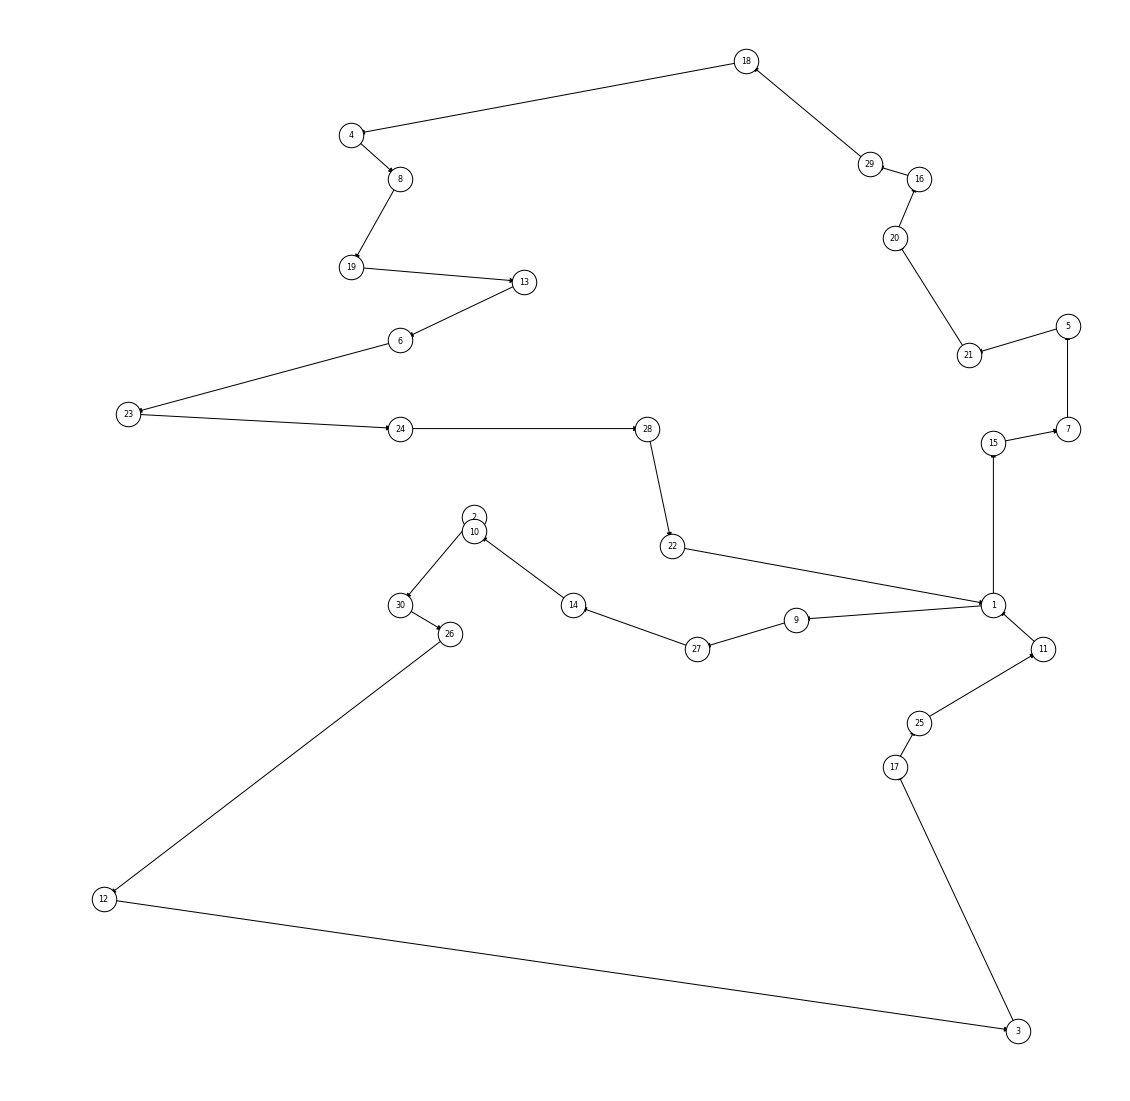

In [43]:
mtsp_mtz.reset()
mtsp_mtz.Params.PreCrush = 1
mtsp_mtz.Params.lazyConstraints = 0
mtsp_mtz.optimize(SEC_cut_callback)


solutions.append(mtsp_mtz.objVal)
print("\n------------------------------------------------------------------------------\n")
print ("-> Solution", mtsp_mtz.objVal)
print("\n------------------------------------------------------------------------------\n")

DrawSol(G, x2)

In [46]:
for i in range(3):
    print("For alternative %d the cost is %d and the objective value is %d" % (i, costs[i], solutions[i]))

For alternative 0 the cost is 3400 and the objective value is 27720
For alternative 1 the cost is 3200 and the objective value is 27720
For alternative 2 the cost is 3300 and the objective value is 29329


We can conclude that the **best alternative** is clearly the **second one**